# DMQC Report: WMO 4901141

## Summary note: ready to go except existing D-mode files have N_HISTORY as a non-unlimited variable, need to fix this. 

## Current status and metadata:

- APEX float that performed 31 cycles in the Labrador Sea
- Deployed May 2010, inactive as of March 2011
- In 'D' mode, gain of 0.84 applied
- Mean gain of 1.06092
- Basically all profiles in audit due to strangely low gain applied
- SCIENTIFIC_CALIB_COMMENT states 'G determined from float measurements in air. See Johnson et al.,2015,doi:10.1175/JTECH-D-15-0101.1', but as far as I can see any data in the traj file for DOXY is FillValues

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4901141 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

\Users\GordonC\Documents\data\Argo\dac\meds\4901141\4901141_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901141\4901141_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901141\4901141_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901141\4901141_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901141\4901141_tech.nc
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data -

## DOXY Audit Status

- If the float has any profiles present in the DOXY audit, which are they are why?
- Likely will usually be left empty/deleted

In [12]:
audit_file = list(Path('../../../audit/').glob('DOXY_WOA*'))[-1]
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(df)

     DAC             PI SPROF DATE_UPDATE DATA MODE      WMO  cycle  \
30  meds  Blair Greenan    06/28/22 20:10         D  4901141      1   
31  meds  Blair Greenan    06/28/22 20:10         D  4901141      2   
32  meds  Blair Greenan    06/28/22 20:10         D  4901141      3   
33  meds  Blair Greenan    06/28/22 20:10         D  4901141      4   
34  meds  Blair Greenan    06/28/22 20:10         D  4901141      5   
35  meds  Blair Greenan    06/28/22 20:10         D  4901141      6   
36  meds  Blair Greenan    06/28/22 20:10         D  4901141      7   
37  meds  Blair Greenan    06/28/22 20:10         D  4901141      8   
38  meds  Blair Greenan    06/28/22 20:10         D  4901141      9   
39  meds  Blair Greenan    06/28/22 20:10         D  4901141     10   
40  meds  Blair Greenan    06/28/22 20:10         D  4901141     11   
41  meds  Blair Greenan    06/28/22 20:10         D  4901141     12   
42  meds  Blair Greenan    06/28/22 20:10         D  4901141     13   
43  me

## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

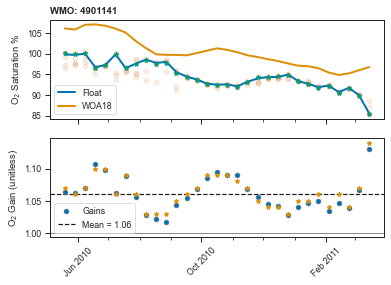

In [13]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: Few cycles but looks pretty good. Good agreement between by calculation and DOXY audit. 

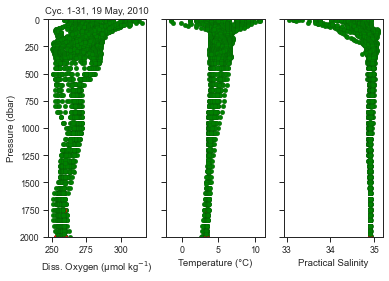

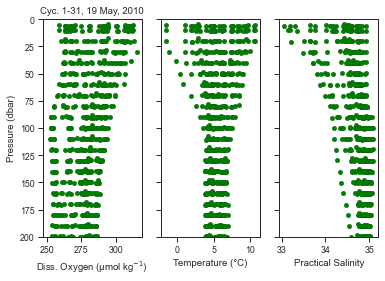

In [14]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: DOXY_QC values are still 1, should change to 3 when I export. 

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.
- Note: I don't visually see any bad data here so nothing is changing. 


Calculating gains using WOA surface data and float O2 percent saturation...
1.0609225538756002


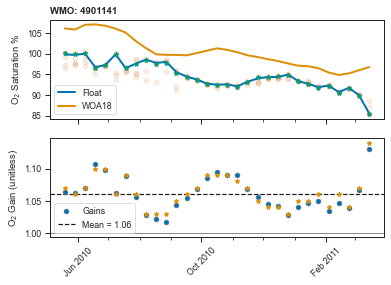

In [15]:
bad_oxygen = [] # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

In [16]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# apply gain and calculate error
flt.update_field('DOXY_ADJUSTED', flt.gain*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))
# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC.isin([0, 3]))
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

File export is breaking right now because for some reason in these files N_HISTORY is NOT and unlimited dimension???

In [17]:
# export the files
flt.export_files(data_mode='D', glob='BD*')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901141/profiles/BD4901141_001.nc...

RuntimeError: NetCDF: Index exceeds dimension bound

In [20]:
nc = Dataset('/Users/GordonC/Documents/data/Argo/dac/meds/4901141/profiles/BD4901141_001.nc')
nc.dimensions

{'DATE_TIME': <class 'netCDF4._netCDF4.Dimension'>: name = 'DATE_TIME', size = 14,
 'STRING256': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING256', size = 256,
 'STRING64': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING64', size = 64,
 'STRING32': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING32', size = 32,
 'STRING16': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING16', size = 16,
 'STRING8': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING8', size = 8,
 'STRING4': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING4', size = 4,
 'STRING2': <class 'netCDF4._netCDF4.Dimension'>: name = 'STRING2', size = 2,
 'N_PROF': <class 'netCDF4._netCDF4.Dimension'>: name = 'N_PROF', size = 1,
 'N_PARAM': <class 'netCDF4._netCDF4.Dimension'>: name = 'N_PARAM', size = 4,
 'N_LEVELS': <class 'netCDF4._netCDF4.Dimension'>: name = 'N_LEVELS', size = 71,
 'N_CALIB': <class 'netCDF4._netCDF4.Dimension'>: name = 'N_CALIB', size = 2,
 'N_HISTORY': <class 'netCDF4._netCDF4.Dime